In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#split data
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle

#pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.compose import make_column_selector

#preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

#models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

#selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, auc, precision_recall_curve

In [2]:
def get_result(y, predict):
    print('f1_score: {}'.format(f1_score(y, predict,average='macro')))
    print('\nconfucsion matrix: \n{}'.format(confusion_matrix(y,predict)))
    print('\nclassification report: \n{}'.format(classification_report(y, predict)))

# Preprocess

## Import dataset and library

In [3]:
train_full = pd.read_csv('../datasets/training.csv').set_index('phone_no_m')

In [4]:
train_full['arpu'] = train_full[['arpu_201908', 'arpu_201909',
       'arpu_201910', 'arpu_201911', 'arpu_201912', 'arpu_202001',
       'arpu_202002', 'arpu_202003']].mean(axis=1)
train_full = train_full.drop(['arpu_201908', 'arpu_201909',
       'arpu_201910', 'arpu_201911', 'arpu_201912', 'arpu_202001',
       'arpu_202002', 'arpu_202003'], axis=1)

In [5]:
X, y = train_full.drop(['city_name','label'],axis=1), train_full['label']
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=0, test_size=0.2)

### Things to do

Here are the things we'll need to do:

***1. Data preprocessing***\
***2. Model selection***\
***3. Hyperparameter tunning***

Data preprocessing:
1. Handle imbalanced dataset -> original, undersampling, oversampling
2. Handle missing data -> impute mean, median, KNN, DecisionTreeModel
3. Handle encoding -> OHE

We will build pipeline to automate the process

In [6]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3907 entries, 912be683c6fdea413ba878f1e808782aa904dc7ef0332e336c7b072ad40349f5debe072b86c5c97db03afff21b8d81291615ad21405341a0a6e40411c77a1d07 to f759d185723a1e33020aba047b14f4c6232254221a95cce50f946a929f4a583447d9706a4e05b85f579ed80ef0e57b149c21c6dae71b52d586956d38e133f3f2
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   county_name                3731 non-null   object 
 1   idcard_cnt                 3907 non-null   int64  
 2   sms_per_receiver           3906 non-null   float64
 3   sms_calltype_1             3906 non-null   float64
 4   sms_calltype_2             3906 non-null   float64
 5   call_dur                   3853 non-null   float64
 6   voc_opposite_no_m          3853 non-null   float64
 7   voc_calltype_1             3853 non-null   float64
 8   voc_calltype_2             3853 non-null   float64
 9   voc_calltype_3            

In [7]:
train_x.head()

,county_name,idcard_cnt,sms_per_receiver,sms_calltype_1,sms_calltype_2,call_dur,voc_opposite_no_m,voc_calltype_1,voc_calltype_2,voc_calltype_3,voc_receive_unique_county,data_with_known_app_no,data_with_known_app_yes,network_usage,arpu
phone_no_m,,,,,,,,,,,,,,,
912be683c6fdea413ba878f1e808782aa904dc7ef0332e336c7b072ad40349f5debe072b86c5c97db03afff21b8d81291615ad21405341a0a6e40411c77a1d07,青羊分公司,4,8.333333,0.048000,0.952000,232.448980,217.0,0.996599,0.003401,0.0,0.0,1.000000,0.000000,0.000000,130.97000
dfaeefa854cc440c5d9aa4760b9f22e28ec2c49b1cb90e0c7bb2aff95272c06926bb7fc2bdb0a7bb53d4498f37726f67907b431fd6241c5c15ab39c471b18f7f,青神分公司,1,6.472803,0.029735,0.970265,195.209302,37.0,1.000000,0.000000,0.0,5.0,0.058824,0.941176,23.875329,105.64375
f625c1df6fbf2e57ec4012dd5650554e4d145a5419067899c15ae3485c8daa2c7875bed507399b64e388646e34832a2b6eb7044d3b85eefd2232438f303b7d07,崇州分公司,3,16.197183,0.020000,0.980000,67.442177,200.0,0.795918,0.204082,0.0,1.0,0.031429,0.968571,3.492575,45.91250
c0081cd7fc67b837d0939db58b047a8b396bc31ac3a19080d437ad86c94b3e18c15ec5d4f172fffdb6902649f9886dd762d24982ad2911f80b86a9100f661831,直管区,2,17.892857,0.075848,0.924152,43.478464,67.0,0.472846,0.527154,0.0,4.0,0.212195,0.787805,47.166810,25.44875
90f23f85ee585a618b7da87f10cf5227a8c37a4350046797ba1029913cb08e7f0f4467dfea429eb76a528dca17cbc756271a617dfb7ef742c1407298da15cf0f,武侯分公司,3,6.180328,0.013263,0.986737,114.437500,37.0,0.928571,0.071429,0.0,5.0,0.106557,0.893443,30.315298,270.93000


## Data preprocessing

### Handle imbalanced dataset

3 ways:
1. Leave as it is but focus on macro f1-score
2. Undersampling
3. Oversampling

In [8]:
#only 32% of the data are spam callers, this is an imbalanced dataset
train_y.describe()

count    3907.000000
mean        0.320706
std         0.466808
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [9]:
majority_class = train_x.loc[train_y==0]
minority_class = train_x.loc[train_y==1]

In [10]:
majority_class.shape, minority_class.shape

((2654, 15), (1253, 15))

In [11]:
undersample_majority = resample(majority_class,n_samples=minority_class.shape[0],random_state=0)
oversample_minority = resample(minority_class,n_samples=majority_class.shape[0],random_state=0)

In [12]:
undersample_majority.shape, oversample_minority.shape

((1253, 15), (2654, 15))

In [13]:
train_x_undersample = pd.concat([undersample_majority,minority_class],axis=0)
train_x_oversample = pd.concat([majority_class,oversample_minority],axis=0)

In [14]:
train_x_undersample = shuffle(train_x_undersample)
train_x_oversample = shuffle(train_x_oversample)

In [15]:
train_y_undersample = train_y[train_x_undersample.index]
train_y_oversample = train_y[train_x_oversample.index]

In [16]:
train_y_undersample.shape, train_y_oversample.shape

((2506,), (5308,))

In [17]:
train_y_undersample.mean(), train_y_oversample.mean()

(0.5, 0.5)

In [18]:
train_x.shape, train_x_undersample.shape, train_x_oversample.shape

((3907, 15), (2506, 15), (5308, 15))

Now we have 3 datasets to work with: original, undersampled and oversampled

### Imputation and OHE

In [19]:
#numeric pipe
num_imputers = dict(impute_mean = SimpleImputer(strategy='mean'), impute_median = SimpleImputer(strategy='median'),
                    model_impute = IterativeImputer(random_state=0, 
                                        estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0)))
num_scaler = dict(none = None, standard=StandardScaler(),
                  minmax_scaler = MinMaxScaler(), quantile_scaler=RobustScaler())
num_pipe = Pipeline([('num_impute',num_imputers['impute_median']),('num_scale',num_scaler['standard'])])

In [20]:
#categorical pipe -> only county name is categorical
county_imputer = SimpleImputer(strategy='most_frequent')
county_ohe = OneHotEncoder(handle_unknown='ignore')
county_pipe = Pipeline([('impute',county_imputer),('ohe',county_ohe)])

In [21]:
#preprocessing pipeline
preprocess_pipe = ColumnTransformer([('numeric',num_pipe,make_column_selector(dtype_exclude='object')),
                                    ('county_name',county_pipe,make_column_selector(dtype_include='object'))])

## Model Selection

In [22]:
models = [RandomForestClassifier(random_state=0, n_jobs=-1), LogisticRegression(random_state=0,n_jobs=-1),
          RidgeClassifier(random_state=0),LinearSVC(max_iter=10000,random_state=0),
          KNeighborsClassifier(n_jobs=-1),
          MLPClassifier(hidden_layer_sizes=(200,200),max_iter=10000,random_state=0),
            SGDClassifier(random_state=0,n_jobs=-1), GradientBoostingClassifier(random_state=0)]

In [23]:
model_pipe = Pipeline([('preprocess',preprocess_pipe),('model',models[1])])

# Compare performance

### Compare original/undersample/oversample dataset performance

we will compare the performance of original, undersampled and oversampled dataset while applying grid search to find out the best combination of models and preprocessing steps for each kind of dataset

In [24]:
params = dict(model=models)

In [25]:
search = GridSearchCV(model_pipe,params,cv=5,verbose=1,
                      return_train_score=True,n_jobs=-1,scoring='f1_macro')

In [26]:
search_undersample = GridSearchCV(model_pipe,params,cv=5,verbose=1,
                                  return_train_score=True,n_jobs=-1,scoring='f1_macro')

In [27]:
search_oversample = GridSearchCV(model_pipe,params,cv=5,verbose=1,
                                 return_train_score=True,n_jobs=-1,scoring='f1_macro')

In [28]:
search.fit(train_x,train_y);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   18.9s finished


In [29]:
search_undersample.fit(train_x_undersample,train_y_undersample);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.4s finished


In [30]:
search_oversample.fit(train_x_oversample,train_y_oversample);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.0s finished


In [31]:
search_result = pd.concat([pd.concat([pd.Series(['original'] * 8,name='data_type'),pd.DataFrame(search.cv_results_)],axis=1),
           pd.concat([pd.Series(['undersample'] * 8,name='data_type'),pd.DataFrame(search_undersample.cv_results_)],axis=1),
          pd.concat([pd.Series(['oversample'] * 8,name='data_type'),pd.DataFrame(search_oversample.cv_results_)],axis=1)],
          axis=0).reset_index(drop=True)\
    [['data_type','param_model','rank_test_score','mean_test_score',
      'std_test_score','mean_train_score', 'std_train_score']].sort_values('mean_test_score',ascending=False)

In [32]:
search_result[['data_type','mean_test_score',
      'std_test_score','mean_train_score', 'std_train_score']].groupby('data_type').\
                mean().sort_values('mean_test_score',ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score
data_type,,,,
oversample,0.867762,0.011024,0.896967,0.003521
original,0.850125,0.009262,0.903101,0.002370
undersample,0.838888,0.014241,0.901259,0.005406


We will be using oversample dataset since it has the best average performance.\
Clearly there is some overfitting issues we need to handle as well (training score is perfect)

### Compare different preprocessing methods

In [33]:
search_result[search_result['data_type'] == 'oversample'].head()

,data_type,param_model,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
16,oversample,"RandomForestClassifier(n_jobs=-1, random_state=0)",1,0.959304,0.005106,0.999953,0.000094
21,oversample,"MLPClassifier(hidden_layer_sizes=(200, 200), m...",2,0.934946,0.012376,0.998069,0.002534
23,oversample,GradientBoostingClassifier(random_state=0),3,0.891751,0.010034,0.915090,0.002456
20,oversample,KNeighborsClassifier(n_jobs=-1),4,0.849441,0.012048,0.900541,0.001210
17,oversample,"LogisticRegression(n_jobs=-1, random_state=0)",5,0.835504,0.007762,0.845332,0.003594


In [34]:
search_result.head()

,data_type,param_model,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
16,oversample,"RandomForestClassifier(n_jobs=-1, random_state=0)",1,0.959304,0.005106,0.999953,0.000094
21,oversample,"MLPClassifier(hidden_layer_sizes=(200, 200), m...",2,0.934946,0.012376,0.998069,0.002534
23,oversample,GradientBoostingClassifier(random_state=0),3,0.891751,0.010034,0.915090,0.002456
0,original,"RandomForestClassifier(n_jobs=-1, random_state=0)",1,0.875358,0.008687,1.000000,0.000000
7,original,GradientBoostingClassifier(random_state=0),2,0.874957,0.005870,0.916739,0.001487


We will use Random Forest, MLP Classifier and GradientBoostingClassifier to test different preprocessing methods since they are the best performed models for oversample and in general

In [35]:
preprocess_models = [RandomForestClassifier(random_state=0, n_jobs=-1),
          MLPClassifier(hidden_layer_sizes=(200,200),max_iter=10000,random_state=0),
            GradientBoostingClassifier(random_state=0)]

In [36]:
preprocess_selection_pipe = Pipeline([('preprocess',preprocess_pipe),('model',preprocess_models[0])])

In [37]:
preprocess_params = dict(model=preprocess_models, preprocess__numeric__num_impute=list(num_imputers.values()),
                         preprocess__numeric__num_scale=list(num_scaler.values()))

In [38]:
search_preprocess = GridSearchCV(preprocess_selection_pipe,preprocess_params,cv=5,verbose=1,
                      return_train_score=True,n_jobs=-1,scoring='f1_macro')

In [39]:
search_preprocess.fit(train_x_oversample, train_y_oversample);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.6min finished


In [40]:
preprocess_result = pd.DataFrame(search_preprocess.cv_results_)\
    [['rank_test_score','param_model','param_preprocess__numeric__num_impute',
      'param_preprocess__numeric__num_scale', 'mean_test_score', 
      'std_test_score','mean_train_score', 'std_train_score']].set_index('rank_test_score').\
        sort_values('mean_test_score',ascending=False)

In [41]:
preprocess_result.head()

,param_model,param_preprocess__numeric__num_impute,param_preprocess__numeric__num_scale,mean_test_score,std_test_score,mean_train_score,std_train_score
rank_test_score,,,,,,,
1,"RandomForestClassifier(n_jobs=-1, random_state=0)",SimpleImputer(),RobustScaler(),0.960246,0.004353,1.000000,0.000000
2,"RandomForestClassifier(n_jobs=-1, random_state=0)",SimpleImputer(),None,0.959870,0.004151,1.000000,0.000000
3,"RandomForestClassifier(n_jobs=-1, random_state=0)",SimpleImputer(),MinMaxScaler(),0.959681,0.004270,1.000000,0.000000
4,"RandomForestClassifier(n_jobs=-1, random_state=0)",SimpleImputer(),StandardScaler(),0.959681,0.004667,1.000000,0.000000
5,"RandomForestClassifier(n_jobs=-1, random_state=0)",SimpleImputer(strategy='median'),RobustScaler(),0.959493,0.005162,0.999953,0.000094


We will focus on random forest with simple imputer and Robust scaler

### Hyperparameter optimising

In [78]:
final_model = RandomForestClassifier(random_state=0, n_jobs=-1)
final_num_pipe = Pipeline([('num_impute',SimpleImputer(strategy='mean')),
                           ('num_scale',RobustScaler())])
final_cat_pipe = Pipeline([('impute',SimpleImputer(strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore'))])
final_preprocess_pipe = ColumnTransformer([('numeric',final_num_pipe,make_column_selector(dtype_exclude='object')),
                                    ('county_name',final_cat_pipe,make_column_selector(dtype_include='object'))])
final_model_pipe = Pipeline([('preprocess',final_preprocess_pipe),
                             ('model',final_model)])

#### search 1

In [79]:
model_params = dict(model__n_estimators=[100,500,1000], model__max_depth=[None, 3, 5, 10],
                   model__max_features=['auto', 22, 10, 5, 3])

In [80]:
search_model = GridSearchCV(final_model_pipe,model_params,cv=5,verbose=1,
                      return_train_score=True,n_jobs=-1,scoring='f1_macro')

In [81]:
search_model.fit(train_x_oversample, train_y_oversample);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


In [82]:
pd.DataFrame(search_model.cv_results_)\
                [['rank_test_score','param_model__max_depth', 'param_model__max_features', 'param_model__n_estimators',
                 'mean_test_score', 'std_test_score','mean_train_score', 'std_train_score']]\
.sort_values('mean_test_score',ascending=False).set_index('rank_test_score').head()

,param_model__max_depth,param_model__max_features,param_model__n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
rank_test_score,,,,,,,
1,None,5,1000,0.962507,0.004190,1.0,0.0
2,None,10,1000,0.962130,0.005474,1.0,0.0
3,None,5,500,0.962130,0.004357,1.0,0.0
4,None,10,500,0.961565,0.005759,1.0,0.0
5,None,3,500,0.961565,0.005476,1.0,0.0


We can fix max depth as None and focus on max features and n_estimators

#### search 2

In [83]:
model_params2 = dict(model__n_estimators=[500,1000,5000],
                   model__max_features=['auto', 10, 5, 3])

In [84]:
search_model2 = GridSearchCV(final_model_pipe,model_params2,cv=5,verbose=1,
                      return_train_score=True,n_jobs=-1,scoring='f1_macro')

In [85]:
search_model2.fit(train_x_oversample, train_y_oversample);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.3min finished


In [86]:
search2_result = pd.DataFrame(search_model2.cv_results_)\
                [['rank_test_score','param_model__max_features', 'param_model__n_estimators',
                 'mean_test_score', 'std_test_score','mean_train_score', 'std_train_score']]\
.set_index('rank_test_score')

In [87]:
search2_result.sort_values('mean_test_score',ascending=False).head()

,param_model__max_features,param_model__n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
rank_test_score,,,,,,
1,5,1000,0.962507,0.004190,1.0,0.0
2,10,1000,0.962130,0.005474,1.0,0.0
3,5,500,0.962130,0.004357,1.0,0.0
4,10,5000,0.961754,0.005213,1.0,0.0
5,10,500,0.961565,0.005759,1.0,0.0


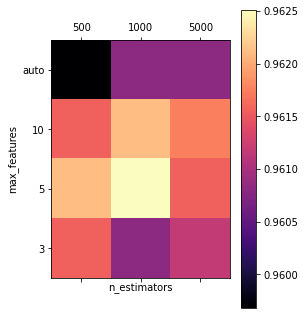

In [88]:
plt.matshow(search2_result['mean_test_score'].values.reshape(4,-1),cmap="magma")
plt.xlabel('n_estimators'), plt.ylabel('max_features')
plt.xticks(ticks=[0,1,2],labels=[500,1000,5000])
plt.yticks(ticks=[0,1,2,3],labels=['auto','10','5','3'])
plt.colorbar()

#### search 3

In [89]:
model_params3 = dict(model__n_estimators=[1000,800,1200],
                   model__max_features=[5, 6, 4])

In [90]:
search_model3 = GridSearchCV(final_model_pipe,model_params3,cv=5,verbose=1,
                      return_train_score=True,n_jobs=-1,scoring='f1_macro')

In [91]:
search_model3.fit(train_x_oversample, train_y_oversample);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.3min finished


In [92]:
search3_result = pd.DataFrame(search_model3.cv_results_)\
                [['rank_test_score','param_model__max_features', 'param_model__n_estimators',
                 'mean_test_score', 'std_test_score','mean_train_score', 'std_train_score']]\
.set_index('rank_test_score')

In [93]:
search3_result.sort_values('mean_test_score',ascending=False).head()

,param_model__max_features,param_model__n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
rank_test_score,,,,,,
1,4,1200,0.962508,0.004887,1.0,0.0
2,5,1000,0.962507,0.004190,1.0,0.0
3,4,1000,0.962319,0.005427,1.0,0.0
4,4,800,0.962130,0.005665,1.0,0.0
5,5,800,0.962130,0.003882,1.0,0.0


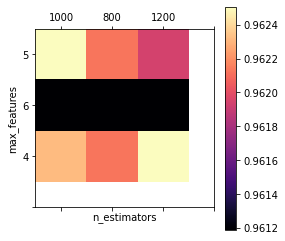

In [95]:
plt.matshow(search3_result['mean_test_score'].values.reshape(3,-1),cmap="magma")
plt.xlabel('n_estimators'), plt.ylabel('max_features')
plt.xticks(ticks=[0,1,2,3],labels=[1000,800,1200])
plt.yticks(ticks=[0,1,2,3],labels=[5, 6, 4])
plt.colorbar()

Let's set our best n_estimators = 1000 and max_features = 5

# Final test

In [96]:
best_model = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=1000, max_features=5)
final_num_pipe = Pipeline([('num_impute',SimpleImputer(strategy='median')),
                           ('num_scale',MinMaxScaler())])
final_cat_pipe = Pipeline([('impute',SimpleImputer(strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore'))])
final_preprocess_pipe = ColumnTransformer([('numeric',final_num_pipe,make_column_selector(dtype_exclude='object')),
                                    ('county_name',final_cat_pipe,make_column_selector(dtype_include='object'))])
final_model_pipe = Pipeline([('preprocess',final_preprocess_pipe),
                             ('model',best_model)])

In [97]:
final_model_pipe.fit(train_x_oversample, train_y_oversample)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc49f1e6550>),
                                                 ('county_name',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='i

In [98]:
prediction = final_model_pipe.predict(test_x)
get_result(test_y, prediction)

f1_score: 0.8896626547302571

confucsion matrix: 
[[648  17]
 [ 72 240]]

classification report: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       665
           1       0.93      0.77      0.84       312

    accuracy                           0.91       977
   macro avg       0.92      0.87      0.89       977
weighted avg       0.91      0.91      0.91       977



We have pretty good precision and recall except for spam caller's recall.\
Let's try to increase our recall now.

## Changing threshold

In [110]:
predict_proba = final_model_pipe.predict_proba(test_x)

In [111]:
precision, recall, thresholds = precision_recall_curve(test_y, predict_proba[:,1])

In [128]:
predict_proba_thresholds = pd.DataFrame(zip(precision, recall, thresholds))
predict_proba_thresholds.columns = ['precision', 'recall', 'thresholds']
predict_proba_thresholds['f1_score'] = (predict_proba_thresholds['precision']*predict_proba_thresholds['recall']/\
        (predict_proba_thresholds['precision']+predict_proba_thresholds['recall']))*2

In [136]:
predict_proba_thresholds.sort_values('f1_score',ascending=False)

,precision,recall,thresholds,f1_score
268,0.894737,0.817308,0.426,0.854271
269,0.897527,0.814103,0.431,0.853782
267,0.891608,0.817308,0.422,0.852843
274,0.906137,0.804487,0.454,0.852292
270,0.897163,0.810897,0.435,0.851852
...,...,...,...,...
468,1.000000,0.032051,0.993,0.062112
469,1.000000,0.028846,0.994,0.056075
470,1.000000,0.025641,0.995,0.050000
471,1.000000,0.016026,0.997,0.031546


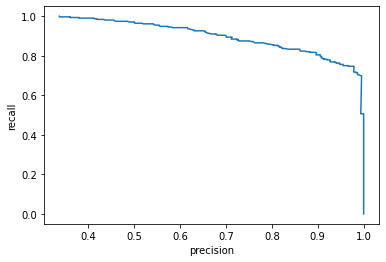

In [132]:
plt.plot(precision,recall)
plt.xlabel('precision'),plt.ylabel('recall');

In [137]:
THRESHOLD = 0.426

In [138]:
get_result(test_y, final_model_pipe.predict(test_x))

f1_score: 0.8896626547302571

confucsion matrix: 
[[648  17]
 [ 72 240]]

classification report: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       665
           1       0.93      0.77      0.84       312

    accuracy                           0.91       977
   macro avg       0.92      0.87      0.89       977
weighted avg       0.91      0.91      0.91       977



In [139]:
get_result(test_y, np.where(final_model_pipe.predict_proba(test_x)[:,1]>THRESHOLD,1,0))

f1_score: 0.8948819262804459

confucsion matrix: 
[[636  29]
 [ 58 254]]

classification report: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       665
           1       0.90      0.81      0.85       312

    accuracy                           0.91       977
   macro avg       0.91      0.89      0.89       977
weighted avg       0.91      0.91      0.91       977



## Validation set

In [140]:
validation = pd.read_csv('../datasets/validation.csv')

In [141]:
validation['arpu'] = validation[['arpu_201908', 'arpu_201909',
       'arpu_201910', 'arpu_201911', 'arpu_201912', 'arpu_202001',
       'arpu_202002', 'arpu_202003']].mean(axis=1)
validation = validation.drop(['arpu_201908', 'arpu_201909',
       'arpu_201910', 'arpu_201911', 'arpu_201912', 'arpu_202001',
       'arpu_202002', 'arpu_202003','city_name'], axis=1).set_index('phone_no_m')

In [142]:
validation_X, validation_y = validation.drop('label',axis=1), validation['label']

In [143]:
valid_predict = final_model_pipe.predict(validation_X)
get_result(validation_y, valid_predict)

f1_score: 0.8647001470758349

confucsion matrix: 
[[810  15]
 [119 278]]

classification report: 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       825
           1       0.95      0.70      0.81       397

    accuracy                           0.89      1222
   macro avg       0.91      0.84      0.86      1222
weighted avg       0.90      0.89      0.89      1222



In [144]:
valid_predict_proba = final_model_pipe.predict_proba(validation_X)
get_result(validation_y, np.where(valid_predict_proba[:,1]>THRESHOLD,1,0))

f1_score: 0.8811669049565092

confucsion matrix: 
[[800  25]
 [ 96 301]]

classification report: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       825
           1       0.92      0.76      0.83       397

    accuracy                           0.90      1222
   macro avg       0.91      0.86      0.88      1222
weighted avg       0.90      0.90      0.90      1222



We have established the best threshold based on all the test data as well.\
We can't adjust the threshold anymore since we don't have any unseen datasets.

# Prediction

In [145]:
combined_X = pd.concat([X, validation_X], axis=0)
combined_y = pd.concat([y, validation_y], axis=0)

In [146]:
combined_X.shape, combined_y.shape

((6106, 15), (6106,))

In [165]:
X_majority_class = combined_X.loc[combined_y==0]
X_minority_class = combined_X.loc[combined_y==1]

In [166]:
X_minority_oversample = resample(X_minority_class, n_samples=X_majority_class.shape[0], random_state=0)

In [167]:
X_majority_class.shape, X_minority_oversample.shape

((4144, 15), (4144, 15))

In [182]:
X_oversample = pd.concat([X_majority_class, X_minority_oversample], axis=0)
X_oversample = shuffle(X_oversample)
y_oversample = combined_y[X_oversample.index]

In [184]:
X_oversample.shape, y_oversample.shape

((8288, 15), (8288,))

In [185]:
X_oversample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8288 entries, 35c2052fc5ecd8038f92052d22a2015b35b42a128efc7aeeed066566ec77adea1351e3ead71ce018a26a49110220a04602736179c9e4adfc5916c2dba2d663dc to 9578c98b8f193d87c9963fb8aff23b720c6170ccbfd817cd1339b3c086a2acc6b91d4488c2d716194b7a2d6df83e7acbc97ca175a1cc3dbe320cd1ab084b857c
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   county_name                7740 non-null   object 
 1   idcard_cnt                 8288 non-null   int64  
 2   sms_per_receiver           8285 non-null   float64
 3   sms_calltype_1             8285 non-null   float64
 4   sms_calltype_2             8285 non-null   float64
 5   call_dur                   8123 non-null   float64
 6   voc_opposite_no_m          8123 non-null   float64
 7   voc_calltype_1             8123 non-null   float64
 8   voc_calltype_2             8123 non-null   float64
 9   voc_calltype_3            

In [186]:
final_model_pipe.fit(X_oversample, y_oversample);

In [187]:
submission_x = pd.read_csv('../datasets/test.csv').\
            rename(columns = {'arpu_202004':'arpu'}).set_index('phone_no_m').drop('city_name',axis=1)
submission_x = submission_x[X_oversample.columns.values]

In [188]:
submission_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2045 entries, 22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf94e017b4ffd67e26520af18637ad91bde69abd831cc36cdc0c5af5e57bc280f95f79efef7bfa9c6926 to 08923b36132be7e0e4739794aa9af2c4ca896dc789e320284772a974ba3804690d4191dbceffc0516186dda9a1ad133ec9b55203a65bc164bfff58ec2594e60c
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   county_name                1978 non-null   object 
 1   idcard_cnt                 2045 non-null   int64  
 2   sms_per_receiver           2008 non-null   float64
 3   sms_calltype_1             2008 non-null   float64
 4   sms_calltype_2             2008 non-null   float64
 5   call_dur                   1965 non-null   float64
 6   voc_opposite_no_m          1965 non-null   float64
 7   voc_calltype_1             1965 non-null   float64
 8   voc_calltype_2             1965 non-null   float64
 9   voc_calltype_3            

In [189]:
test_predict_proba = final_model_pipe.predict_proba(submission_x)
submission_predict = np.where(test_predict_proba[:,1]>THRESHOLD,1,0)

In [194]:
submission_predict = final_model_pipe.predict(submission_x)

In [195]:
submission_predict.mean()

0.2938875305623472

In [196]:
submission = pd.DataFrame({'phone_no_m':submission_x.index.values,'label':submission_predict})

In [197]:
submission.head()

,phone_no_m,label
0,22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf...,1
1,5220d4b8429bdba3971a7b46a088c6b8fa6710f4060759...,1
2,7d19dd2b50ced56f03d23bf928cf34dc570a48525571a8...,0
3,134a4a591185c9d3788021896dcfc235e9e0a6a1e3f8a4...,1
4,2356dcd6759d50455ddaeed03c838843558e9182d5962f...,0


In [198]:
submission.to_csv('../datasets/submission_v2.csv',index=False)

In [200]:
X_oversample.to_csv('../datasets/X_oversample.csv', index=False)

In [201]:
y_oversample.to_csv('../datasets/y_oversample.csv', index=False)

In [202]:
submission_x.to_csv('../datasets/submission_rename.csv', index=False)